In [1]:
# 그래프 출력 관련 설정
# 아래 코드는 그래프를 그리고 싶을때 그대로 가져다가 한번 실행시켜주면 편합니다.
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns

sns.set_style("white")

%config InlineBackend.figure_format = 'retina'
mpl.rcParams['axes.unicode_minus'] = False # 마이너스 표시 문제
mpl.rcParams['figure.figsize'] = (15,8)
	
# 한글 폰트 설정
path = 'data/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=path, size=18).get_name()
plt.rc('font', family=font_name)
# fm._rebuild() => Colab에서는 이 코드도 실행해주세요

In [2]:
# 엑셀 등의 데이터를 편리하게 다룰수 있는 pandas 라이브러리
import pandas as pd
import numpy as np

In [3]:
# pandas의 read_csv 함수를 사용해서 'data_3351_20221005.csv' 파일을 읽어옵니다.
# 'data_3351_20221005.csv'데이터는 한국거래소(KRX)에서 가져온 코스피200 데이터 입니다.
코스피200 = pd.read_csv('data/data.csv', encoding='cp949')

In [4]:
# 데이터가 어떻게 구성되어있는지 3개만 확인해보겠습니다
코스피200.head(3)

,일자,종가,대비,등락률,시가,고가,저가,거래량,거래대금,상장시가총액
0,2022/11/02,303.87,-0.01,0.00,302.49,305.10,302.02,190405.0,7239980.0,1.619881e+09
1,2022/11/01,303.88,4.30,1.44,300.53,304.01,299.84,272490.0,7030448.0,1.618958e+09
2,2022/10/31,299.58,4.52,1.53,298.61,300.05,296.45,121050.0,6465630.0,1.589522e+09


In [5]:
# 결측치(셀에 값이 없음)를 제거합니다.
코스피200 = 코스피200.dropna()

# 데이터를 그대로 뿌리면, 최근일자부터 그래프가 그려져서
# 일자별로 정렬해서 데이터프레임을 다시 저장했습니다.
코스피200 = 코스피200.sort_values('일자')

In [6]:
# 그래프의 x축에 쓸 글자(라벨) 만들기
label_x = 코스피200['일자'].loc[[ i for i in range(0, len(코스피200), 365) ]].to_list()

In [7]:
# 처음 읽어온 코스피200 데이터는 모두 float64 자료형입니다 (float64: 64비트범위내에서 표현한 실수)
코스피200.dtypes

일자         object
종가        float64
대비        float64
등락률       float64
시가        float64
고가        float64
저가        float64
거래량       float64
거래대금      float64
상장시가총액    float64
dtype: object

In [8]:
##### 주봉 데이터를 계산하기 위한 준비 1

# float64 자료형으로 된 일자 데이터를 datetime 자료형으로 변환합니다.
# 일자데이터를 datetime으로 변환해주어야 다음 셀에서 resample함수를 적용할 수 있습니다.
코스피200['일자'] = pd.to_datetime(코스피200['일자'])
코스피200.set_index('일자', inplace=True)

In [9]:
##### 주봉데이터 만들기

# agg 함수로 각 컬럼에 적용할 함수명을 딕셔너리로 정의해줍니다.
# 시가 : 데이터프레임 클래스의 first함수 = 시가 그룹 데이터 중 가장 첫번쨰 데이터
# 고가 : 데이터프레임 클래스의 max 함수 = 고가 그룹 데이터 중 최대값
# 저가 : 데이터프레임 클래스의 min 함수 = 시가 그룹 데이터 중 최소값
# 종가 : 데이터프레임 클래스의 first 함수 = 시가 그룹 데이터 중 가장 마지막 데이터
agg_dict = {'시가': 'first',
          '고가': 'max',
          '저가': 'min',
          '종가': 'last'}

# resample 함수는 원하는 주기로 데이터를 나누어주는 함수입니다.
# W-Fri와 같이 리샘플링 기준을 작성합니다. W-Fri는 매주 금요일을 의미합니다.
# 그리고 나서 바로 데이터프레임의 집계를 하는 함수인 agg를 사용합니다.
# agg를 쓸때는 앞에 딕셔너리로 만들어준 집계조건(agg_dict)를 인자로 사용합니다.
코스피200_주봉 = 코스피200.resample('W-Fri').agg(agg_dict)
코스피200_주봉 = 코스피200_주봉.dropna()

코스피200_주봉.head(3)

,시가,고가,저가,종가
일자,,,,
2001-06-15,75.95,77.09,74.43,76.35
2001-06-22,76.15,76.41,72.43,73.59
2001-06-29,73.36,73.98,71.35,73.20


In [10]:
# 일자를 기준으로 컬럼의 lineplot을 그려주는 함수 만들기
def show_graph(column_name, str_date):
    sub_data = 코스피200_주봉[코스피200_주봉.index >= str_date]

    ax = sns.lineplot(x=sub_data.index, y=sub_data[column_name], linewidth=5)
    sns.lineplot(x=sub_data.index, y=sub_data['MA20'], linewidth=1)
    

    # 마커를 표시합니다.
    # 인터넷에 matplotlib marker color, matplotlib marker character 로 검색해서 종류를 변경해보세요
    # ^는 삼각형(위), v는 삼각형(아래),r은 red, b는 blue를 의미합니다.
    # 색상, 모양, 크기(markersize)는 변경할 수 있습니다.
    ax.plot(sub_data.index, sub_data['break_up_20'], "r^", markersize=15)
    ax.plot(sub_data.index, sub_data['break_down_20'], "bv", markersize=15)

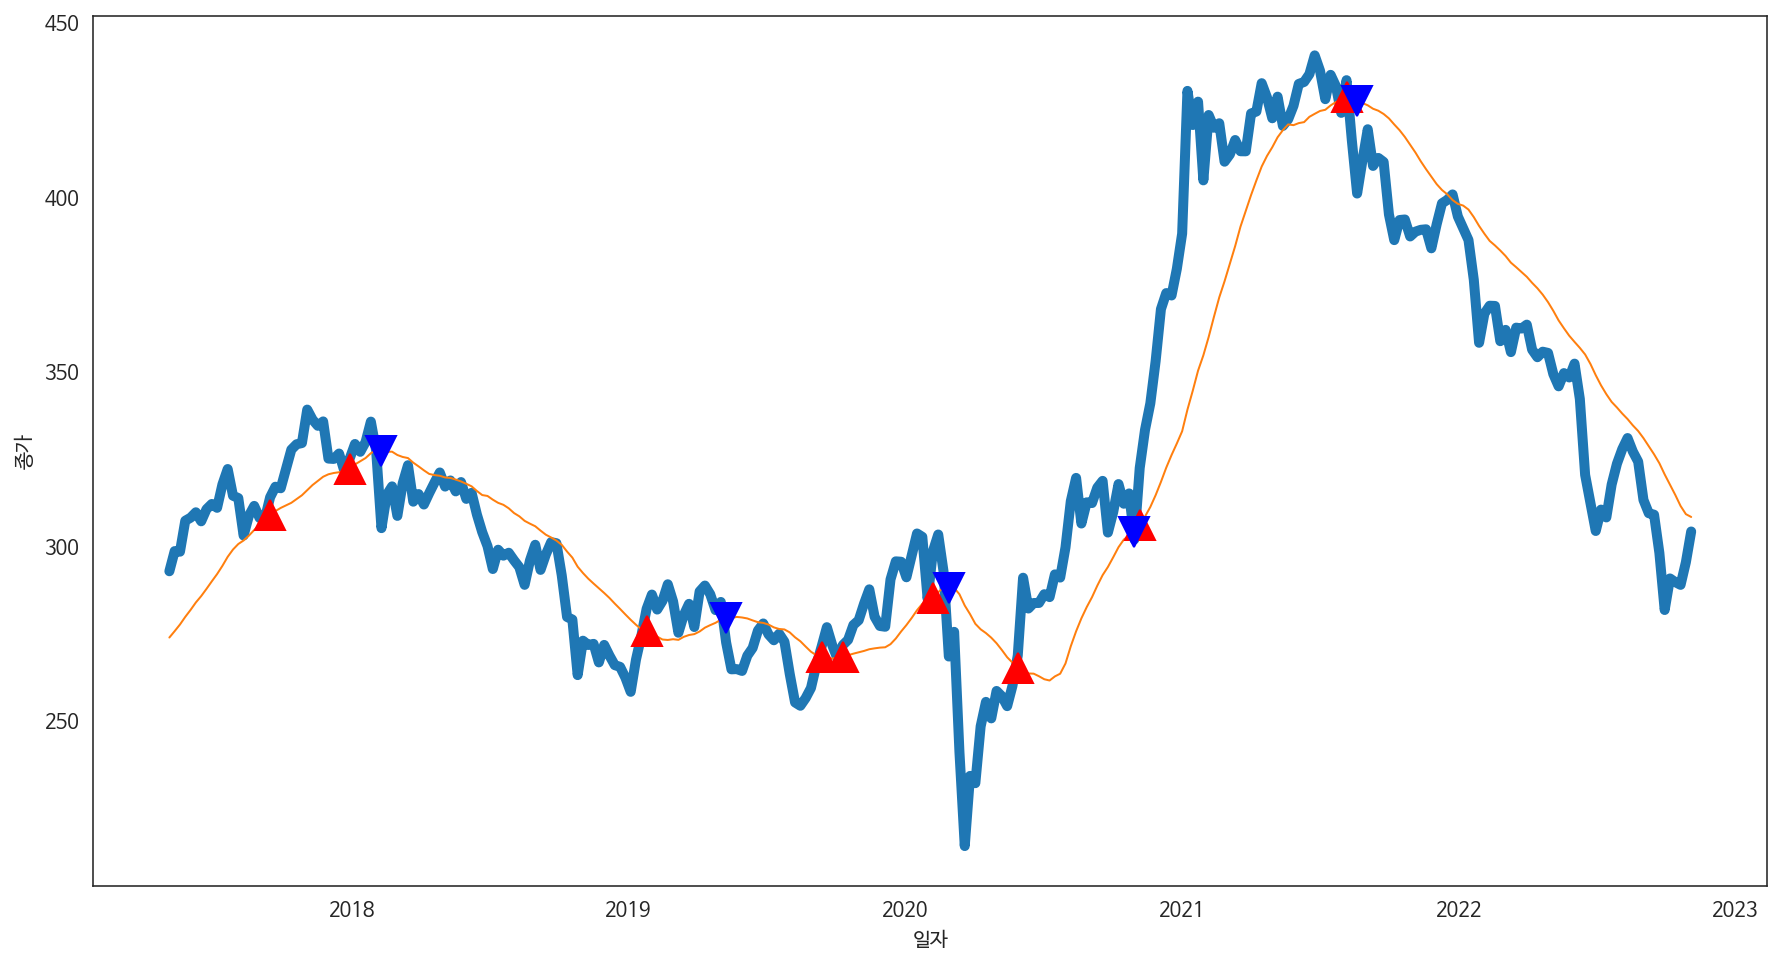

In [11]:
from datetime import timedelta

코스피200_주봉['MA20'] = 코스피200_주봉['종가'].rolling(window=20).mean()
코스피200_주봉['break_up_20'] = np.nan
코스피200_주봉['break_down_20'] = np.nan

a_day = timedelta(days=1)

date_주봉 = 코스피200_주봉.index

# 이전에 매수를 했는지 매도를 했는지 기억하기 위한 변수를 만들겠습니다.
이전_Action = None

for i in range(1, len(코스피200_주봉)):
    이번주 = date_주봉[i]
    저번주 = date_주봉[i-1]

    상승매수_조건1 = 코스피200_주봉.loc[저번주, '종가'] < 코스피200_주봉.loc[이번주, 'MA20']
    상승매수_조건2 = 코스피200_주봉.loc[이번주, '종가'] > 코스피200_주봉.loc[이번주, 'MA20']
    상승매수_조건3 = 코스피200_주봉.loc[이번주, '종가'] >= 코스피200_주봉.loc[저번주, '종가'] * 1.01

    if 상승매수_조건1 and 상승매수_조건2 and 상승매수_조건3:
        코스피200_주봉.loc[이번주, 'break_up_20'] = 코스피200_주봉.loc[이번주, 'MA20']
        # 상승매수 조건 만족했으므로 매수
        이전_Action = '매수'

    하락매도_조건1 = 코스피200_주봉.loc[저번주, '종가'] > 코스피200_주봉.loc[이번주, 'MA20']
    하락매도_조건2 = 코스피200_주봉.loc[이번주, '종가'] < 코스피200_주봉.loc[이번주, 'MA20']
    하락매도_조건3 = 코스피200_주봉.loc[이번주, '종가'] <= 코스피200_주봉.loc[저번주, '종가'] * 0.96
    ### [[ 추가된 하락 매도 조건입니다 ]]
    # 이번주 종가가 20주 이평선보다 4% 이하로 떨어진 가격인데 이전에 매수를 했었는지
    하락매도_조건4 = (코스피200_주봉.loc[이번주, '종가'] < 코스피200_주봉.loc[이번주, 'MA20'] * 0.96) and 이전_Action == '매수'

    ### [[ 추가된 하락 매도 조건을 업데이트합니다. ]]
    # 다른 "하락매도 조건이 발생하지 않아도 조건4를 만족하면 무조건 매도한다"는 의도로 조건식을 작성했습니다
    if (하락매도_조건1 and 하락매도_조건2 and 하락매도_조건3) or 하락매도_조건4:
        코스피200_주봉.loc[이번주, 'break_down_20'] = 코스피200_주봉.loc[이번주, 'MA20']
        #하락매도 조건 만족했으므로 매도
        이전_Action = '매도'

show_graph('종가', '2017/05/01')

# ▼ 맨 마지막 큰 하락 직전에 매도시점을 잘 파악한 모습입니다.

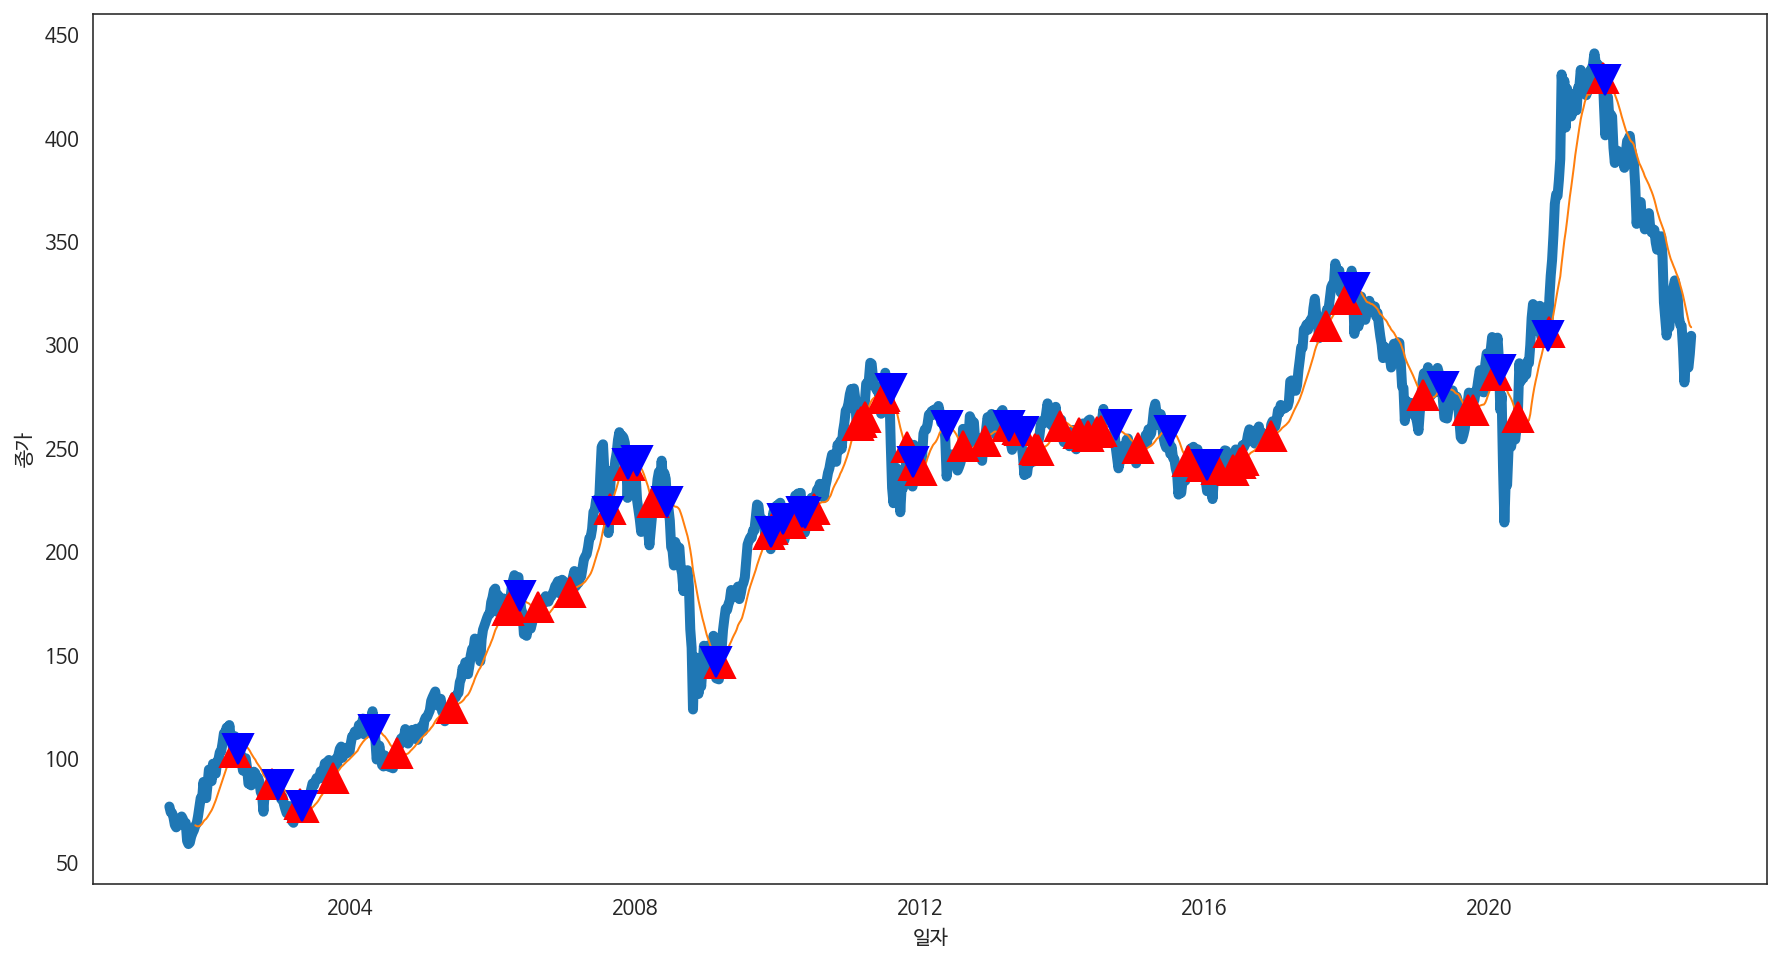

In [12]:
# 매수매도 시점이 합리적인지...? 전체 기간에 대해서 시각화
show_graph('종가', '1960/01/01')

In [13]:
# 매수/매도 시점에 거래 시뮬레이션
초기금액 = 1000000
현금 = 초기금액
보유수량 = 0

# 매수/매도시 조건
# 매수 타이밍에는 보유 현금의 80%를 매수하고
# 매도 타이밍에는 보유 주식의 50%를 매도해보겠습니다.
매수비율 = 0.80     # 한번 살때 현금의 몇배나 매수 할것인지?
매도비율 = 0.50     # 한번 팔때 보유 수량의 몇배나 매도 할것인지?

코스피200_주봉['현금'] = np.nan
코스피200_주봉['주식수'] = np.nan
코스피200_주봉['보유비율'] = np.nan

# 매수 동작
# 해당주 종가 기준으로 매수한다고 가정
def Buy(날짜):
    global 현금
    global 보유수량
    가용매수자금 = int(현금 * 매수비율)
    해당날짜_주가 = 코스피200_주봉.loc[날짜, '종가']
    매수가능_주식수 = 가용매수자금 // 해당날짜_주가

    보유수량 += 매수가능_주식수
    현금 -= 매수가능_주식수 * 해당날짜_주가

# 매도 동작
# 해당주 종가 기준으로 매도한다고 가정
def Sell(날짜):
    global 현금
    global 보유수량
    해당날짜_주가 = 코스피200_주봉.loc[날짜, '종가']
    매도가능_수량 = int(보유수량 * 매도비율)
    
    현금 += 해당날짜_주가 * 매도가능_수량
    보유수량 -= 매도가능_수량

def Update_잔고(날짜):
    해당날짜_주가 = 코스피200_주봉.loc[날짜, '종가']
    해당날짜_주식자산 = 보유수량 * 해당날짜_주가

    코스피200_주봉.loc[날짜, '현금'] = 현금
    코스피200_주봉.loc[날짜, '주식수'] = 보유수량
    코스피200_주봉.loc[날짜, '보유비율'] = 해당날짜_주식자산 / (현금 + 해당날짜_주식자산) * 100

In [14]:
# 전체 기긴에 대해 찾아낸 매수/매도 시점에서
# 매수하고 매도하는 코드입니다.
for iter in 코스피200_주봉.itertuples():
    if iter.break_up_20 != np.nan:
        Buy(iter.Index)
    
    if iter.break_down_20 != np.nan:
        Sell(iter.Index)

    Update_잔고(iter.Index)

# 결과 출력
주식평가금액 = 보유수량 * 코스피200_주봉.iloc[-1]['종가']
총자산금액 = int(현금 + 주식평가금액)
print("총자산 금액:", 총자산금액, "원" )
print("현금 평가금액:", int(현금), "원" )
print("주식 평가금액: %d 원 (%d 주)" % (주식평가금액, 보유수량) )
print("수익률: %.2f %%" % ((총자산금액 - 초기금액) / 초기금액 * 100) )

# ▼ 전체기간에 대해서 해당 전략으로 투자한 결과입니다.
#   수익률이 110.12%.....

총자산 금액: 2101215 원
현금 평가금액: 1165599 원
주식 평가금액: 935615 원 (3079 주)
수익률: 110.12 %


In [15]:
# 일자를 기준으로 현금/주식 보유량 시각화
def show_graph2(column_name, str_date):
    sub_data = 코스피200_주봉[코스피200_주봉.index >= str_date]

    sns.lineplot(x=sub_data.index, y=sub_data[column_name], linewidth=3)
    #sns.lineplot(x=sub_data.index, y=sub_data['MA20'], linewidth=1)
    ax2 = plt.twinx()
    ax2.plot(sub_data['현금'], 'g--')
    ax3 = plt.twinx()
    ax3.plot(sub_data['주식수'], 'c--')

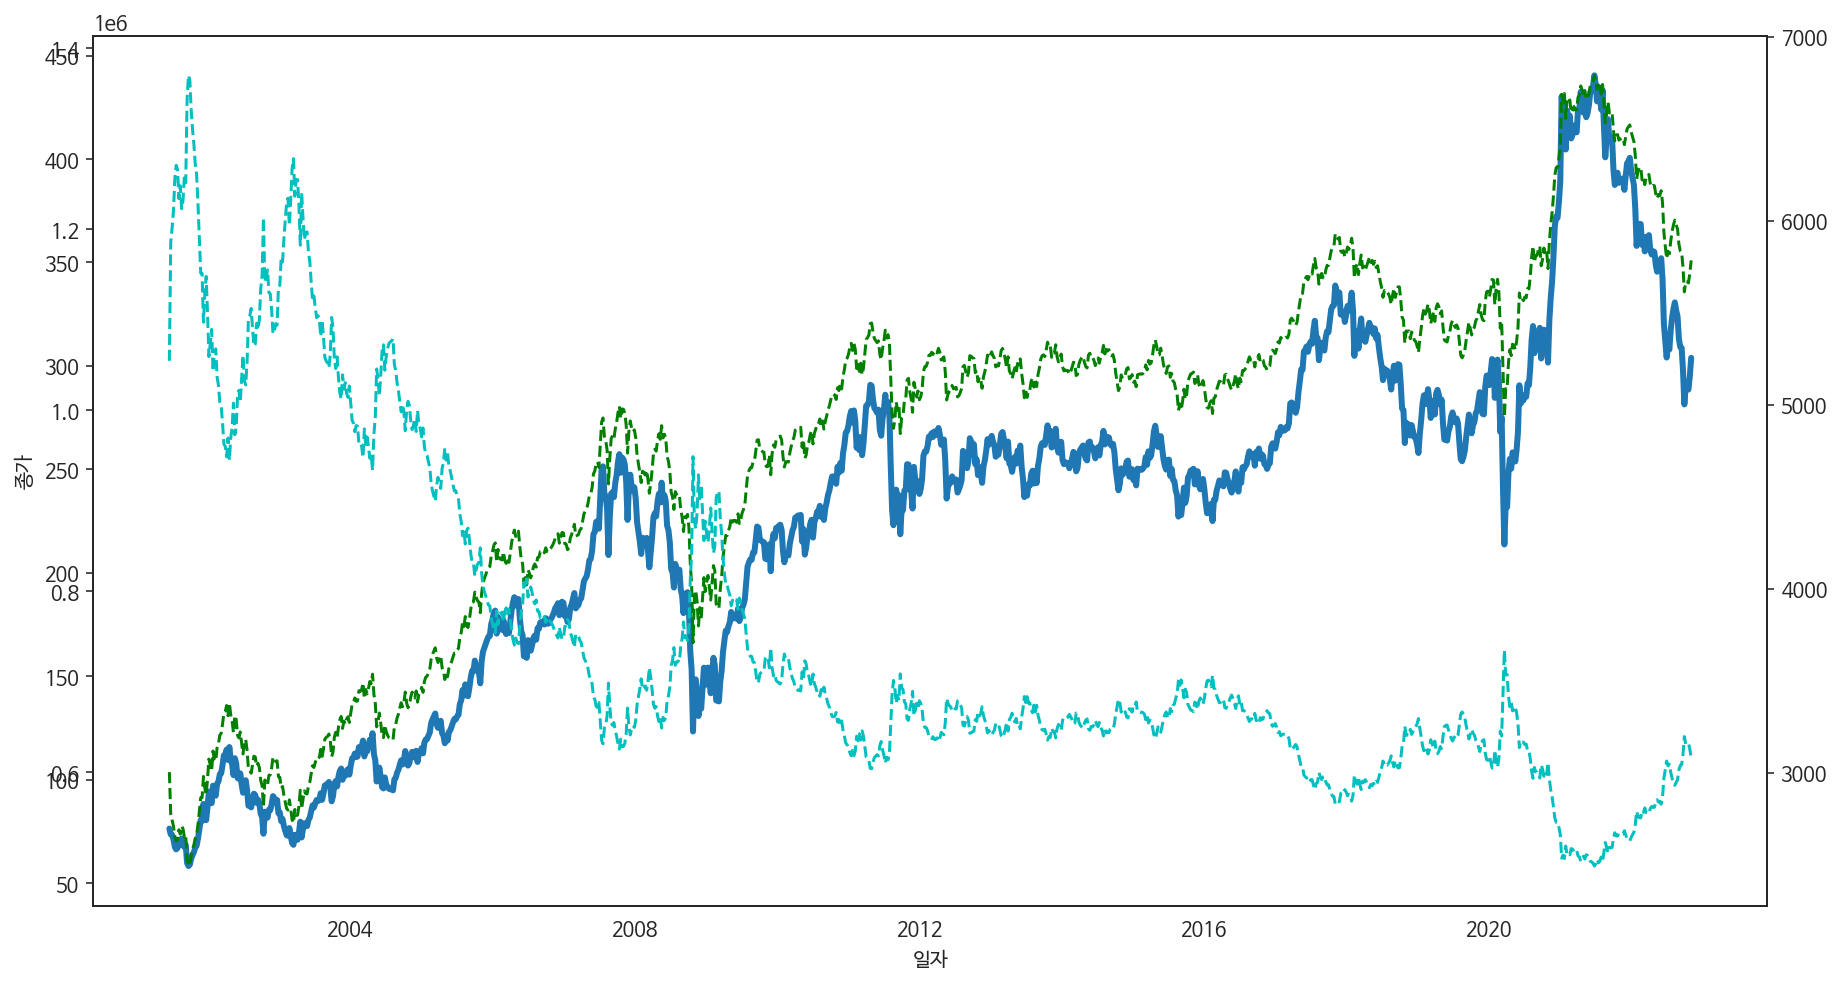

In [16]:
show_graph2('종가', '1960/01/01')

In [17]:
# 리먼브라더스 사태가 일어나기 직전년도(2008년 이전)부터 투자를 시작했다고 가정해보겠습니다.
# 매수/매도 시점에 거래 시뮬레이션
초기금액 = 1000000
현금 = 초기금액
보유수량 = 0

매수비율 = 0.80
매도비율 = 0.50

for iter in 코스피200_주봉[코스피200_주봉.index >= '2007/01/01'].itertuples():
    if iter.break_up_20 != np.nan:
        Buy(iter.Index)
    
    if iter.break_down_20 != np.nan:
        Sell(iter.Index)

    Update_잔고(iter.Index)

# 결과 출력
주식평가금액 = 보유수량 * 코스피200_주봉.iloc[-1]['종가']
총자산금액 = int(현금 + 주식평가금액)
print("총자산 금액:", 총자산금액, "원" )
print("현금 평가금액:", int(현금), "원" )
print("주식 평가금액: %d 원 (%d 주)" % (주식평가금액, 보유수량) )
print("수익률: %.2f %%" % ((총자산금액 - 초기금액) / 초기금액 * 100) )

총자산 금액: 1371378 원
현금 평가금액: 760903 원
주식 평가금액: 610474 원 (2009 주)
수익률: 37.14 %


In [18]:
# 제가 입사한 2017년부터 투자를 시작했다고 가정해보겠습니다.
초기금액 = 1000000
현금 = 초기금액
보유수량 = 0

매수비율 = 0.80
매도비율 = 0.50

for iter in 코스피200_주봉[코스피200_주봉.index >= '2017/01/01'].itertuples():
    if iter.break_up_20 != np.nan:
        Buy(iter.Index)
    
    if iter.break_down_20 != np.nan:
        Sell(iter.Index)

    Update_잔고(iter.Index)

# 결과 출력
주식평가금액 = 보유수량 * 코스피200_주봉.iloc[-1]['종가']
총자산금액 = int(현금 + 주식평가금액)
print("총자산 금액:", 총자산금액, "원" )
print("현금 평가금액:", int(현금), "원" )
print("주식 평가금액: %d 원 (%d 주)" % (주식평가금액, 보유수량) )
print("수익률: %.2f %%" % ((총자산금액 - 초기금액) / 초기금액 * 100) )

총자산 금액: 1092099 원
현금 평가금액: 605907 원
주식 평가금액: 486192 원 (1600 주)
수익률: 9.21 %


In [19]:
# 2020년부터 투자를 시작했다고 가정해보겠습니다.
초기금액 = 1000000
현금 = 초기금액
보유수량 = 0

매수비율 = 0.80
매도비율 = 0.50

for iter in 코스피200_주봉[코스피200_주봉.index >= '2020/01/01'].itertuples():
    if iter.break_up_20 != np.nan:
        Buy(iter.Index)
    
    if iter.break_down_20 != np.nan:
        Sell(iter.Index)

    Update_잔고(iter.Index)

# 결과 출력
주식평가금액 = 보유수량 * 코스피200_주봉.iloc[-1]['종가']
총자산금액 = int(현금 + 주식평가금액)
print("총자산 금액:", 총자산금액, "원" )
print("현금 평가금액:", int(현금), "원" )
print("주식 평가금액: %d 원 (%d 주)" % (주식평가금액, 보유수량) )
print("수익률: %.2f %%" % ((총자산금액 - 초기금액) / 초기금액 * 100) )

총자산 금액: 1037441 원
현금 평가금액: 575559 원
주식 평가금액: 461882 원 (1520 주)
수익률: 3.74 %
